##### Step 1: Find a Bird Image

Searching for 'bird photos'


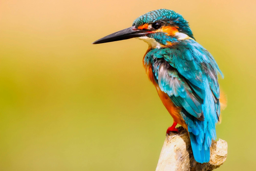

In [10]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

urls = search_images('bird photos', max_images=1)
urls[0]

dest = 'Resources/Bird-Classification/bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

##### Step 2: Build a data set of photos for classification of birds / forests using a range of lighting conditions.

In [11]:
from pathlib import Path
from time import sleep

searches = 'forest','bird'
path = Path('Resources/Bird-Classification/bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


##### Step 3: Remove failed downloads

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

##### Step 4: Create the data loader to hold the training set

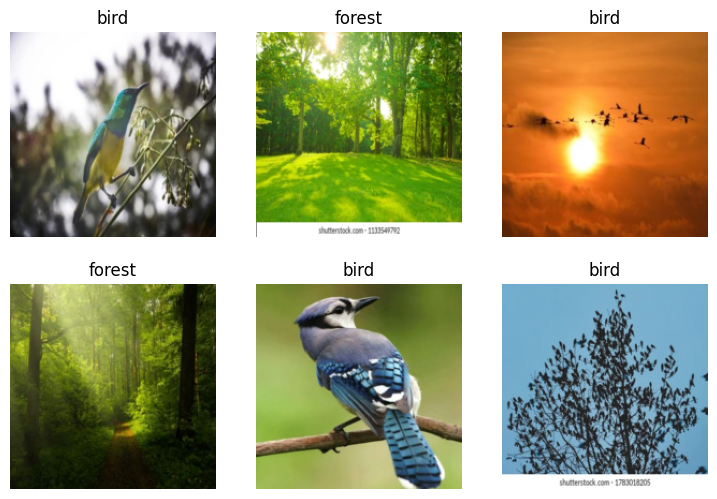

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

##### Step 5: Train the model

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.548446,0.002088,0.000000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.043881,0.000789,0.000000,00:01
1,0.036946,0.000093,0.000000,00:01
2,0.027240,0.000354,0.000000,00:01
3,0.019724,0.000086,0.000000,00:01
4,0.014628,0.000049,0.000000,00:01


##### Step 6: Use the model on the original photo.

In [6]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
